# CPP-OTX2 Image Analysis
### Jonathan Ramos 10/6/2023

The original csvs for this round of image analysis were generated by polygon, NOT pipsqueak. Because of this change I reworked most of the existing functions to be optimized for the new csv format.
Notably, Single and Colocalized data have slightly different formats and col names. We must standardize col names (or at least only inspect cols with identical names), in particular we must have cols with the following names:

- 'filename'
- 'image_name'
- 'stain_type'
- 'rat_n'
- 'treatment'

The remaining cols are only used to ensure duplicate rows are removed and are otherwise not used for intensity analysis. 'filename' is a col already included in csvs spat out by Polygon. 'image_name', 'stain_type', 'rat_n', and 'treatment' are all cols that I built during while cleaning and preparing data for analysis. 
NOTE: that the 'filename' cols between csvs for single-labeled data and colocalized data do NOT mean the same thing. This doesn't really matter as long as they are unique PER STAIN TYPE PER IMAGE.

### Cleaning up single-labeled data

In [1]:
import numpy as np
import pandas as pd
import glob


# load in data
dir_path = 'FULL_CPP1-OTX2_analysis_results__9-19-2023'
files = [f for f in glob.glob(f'{dir_path}/*/*.csv') if not 'batch_export' in f]   # note: NOT batch_export
dfs = [pd.read_csv(f) for f in files]

# from the cohort key we have the following assignmnets:
scFv_OTX2 = {'rat2', 'rat4', 'rat6', 'rat7'}    # this is the treatment we're interested in
dIgK_OTX2 = {'rat1', 'rat3', 'rat5'}            # this is the control

# building a cohort key dict
rats = [f'rat{i}' for i in range(1, 8)]
treatments =  ['dIgK_OTX2' if rat in dIgK_OTX2 else 'scFv_OTX2' for rat in rats]
d_treatment = dict(zip(rats, treatments))

# before concat, first check that all columns match
cols = dfs[0].columns
for df in dfs:
    if False in df.columns == cols:
        print('check your columns')

# removing whitespace char ' ' from col names
new_cols = [''.join(col.split(' ')) for col in cols]
# new_colr = [col.replace(' ', '') for col in cols]

for df in dfs:
    df.columns = new_cols

# time to clean things up
for df in dfs:
    fnames = np.unique(df.filename)
    if len(df) == 0:
        pass    # we don't care about empty files

    # there's a serious problem if there is more than one unique string in 'filename' col per file.
    if len(fnames) >= 2:
        print(f'check the following files: {fnames}')

    # we expect exactly one unique string in 'filename' col per file
    if len(fnames) == 1:
        fname = np.unique(df.filename).item()

        # let's just create a new col (with a more informative name) rather than setting over the old one
        # we can tell the stain-type based on the end of the file name
        if fname[-6:] == '_2.tif':
            df['stain_type'] = 'PV'
        if fname[-6:] == '_3.tif':
            df['stain_type'] = 'cFos'
        if fname[-6:] == '_4.tif':
            df['stain_type'] = 'WFA'

        ##### while i'm here i might as well add all the other labels:

        # rat_n
        split = fname.split('_')
        for s in split:
            if 'rat' in s.lower():
                df['rat_n'] = s.lower()

        # image_name, note: this is NOT the same as filename
        df['image_name'] = ''.join(fname[:-6].split(' '))

        # lastly, mapping rat_ns to treatment groups so we know which animals to normalize the data to
        df['treatment'] = df.rat_n.map(d_treatment)

# concat all single-labeled data
df_single = pd.concat(dfs)
print(f'\n df_single shape: {np.shape(df_single)}')

# write cleaned set to csv 
df_single.to_csv('CPP-OTX2_single_cleaned.csv')
df_single.head()    # the new cols we added will be on the right side


 df_single shape: (5575, 41)


,cell_number,roi_id,roi_source,roi_type,CoM_x,CoM_y,pixel_area,background,mean_intensity,median_intensity,...,roundness,solidity,skewness,kurtosis,filename,analysis_date,stain_type,rat_n,image_name,treatment
0,1,001-00000,WFA,RECT,84.15,107.63,725.0,379.318,313.5476,267.0,...,0.8621,1.0,2.7944,12.0583,CPP1 OTX2_PL_RAT7_E2_4.tif,Wed Sep 20 10:59:01 PDT 2023,WFA,rat7,CPP1OTX2_PL_RAT7_E2,scFv_OTX2
1,2,001-00001,WFA,RECT,160.11,267.51,240.0,379.318,733.5208,439.0,...,0.6000,1.0,0.8049,-0.8848,CPP1 OTX2_PL_RAT7_E2_4.tif,Wed Sep 20 10:59:01 PDT 2023,WFA,rat7,CPP1OTX2_PL_RAT7_E2,scFv_OTX2
2,3,001-00002,WFA,RECT,73.61,154.82,529.0,379.318,457.2665,440.0,...,1.0000,1.0,0.5075,0.1160,CPP1 OTX2_PL_RAT7_E2_4.tif,Wed Sep 20 10:59:01 PDT 2023,WFA,rat7,CPP1OTX2_PL_RAT7_E2,scFv_OTX2
3,4,001-00005,WFA,RECT,204.53,433.90,756.0,379.318,430.7937,404.0,...,0.9643,1.0,0.8008,0.5260,CPP1 OTX2_PL_RAT7_E2_4.tif,Wed Sep 20 10:59:01 PDT 2023,WFA,rat7,CPP1OTX2_PL_RAT7_E2,scFv_OTX2
4,5,001-00006,WFA,RECT,181.73,329.01,552.0,379.318,544.7826,475.0,...,0.9583,1.0,0.9508,0.4453,CPP1 OTX2_PL_RAT7_E2_4.tif,Wed Sep 20 10:59:01 PDT 2023,WFA,rat7,CPP1OTX2_PL_RAT7_E2,scFv_OTX2


### Cleaning up colocalized data

In [2]:
# load in data
dir_path = 'CPP1-OTX2_Coloc_Results_Total'
files = [f for f in glob.glob(f'{dir_path}/*.csv')] 
dfs = [(f, pd.read_csv(f)) for f in files]

dfs_coloc = []
for f, df in dfs:
    df['csvfile'] = f.split('/')[-1]
    dfs_coloc.append(df)

# again we have disgusting column names that each begin with a whitespace char
# all these csvs should have the same column names, just spot check a few to be sure.
columns = [''.join(col.split(' ')) for col in dfs_coloc[0].columns]

# the character '/' causes issues when we try to write to disk (the computer thinks it's a path)
# so let's replace that with something better. 
# For consitency, also changing c-Fos to cFos, Parvalbumin to PV, and stain to stain_type
columns = [col.replace('w/', '_w_').replace('c-Fos', 'cFos').replace('Parvalbumin', 'PV').replace('stain', 'stain_type') for col in columns]

# setting new column names
for df in dfs_coloc:
    df.columns = columns

# check that each coloc csv comes from exactly three unique filenames (these fnames are uninformative)
for df in dfs_coloc:
    assert len(np.unique(df['filename'])) == 3

# REPLACING 'HAND-DRAWN' WITH APPROPRIATE STAIN-TYPE LABEL
for df in dfs_coloc:
    for fname in np.unique(df['filename']):
        stains = np.unique(df[df['filename'] == fname].stain_type).tolist()

        if 'hand-drawn' in stains:
            # NOTE: we must have for each stain type combination, at least one ROI was NOT hand-drawn to use as a reference
            stains.remove('hand-drawn')

            # check that the len of stains is EXACTLY one 
            # if this asssertion fails check the offending csv by hand.
            assert len(stains) == 1
            stain_type = stains[0]
            
            # conditional replacement 
            df.loc[(df.filename == fname) & (df.stain_type == 'hand-drawn'), 'stain_type'] = stain_type

        if not 'hand-drawn' in stains:
            # again, if this assertion fails, check the offending csv by hand.
            assert len(stains) == 1

    # now adding all the other necessary identifying columns, as we did earlier for the single labeled data above
    csvfile = np.unique(df.csvfile).item()

    # image_name
    image_name = csvfile.replace('_coloc_results.csv', '')
    df['image_name'] = image_name

    # rat_n
    for substr in image_name.split('_'):
        if 'rat' in substr.lower():
            df['rat_n'] = substr.split('-')[0].lower()

    # treatment
    df['treatment'] = df.rat_n.map(d_treatment)

    # lastly changing stain type strings for consitency.
    # loc on partial string match via str.contains() because some stains labeled as 'PV (TF2)', 'WFA (TF2), and 'c-Fos (TF2)'
    # I assume these should just be PV, WFA and cFos respectively
    df.loc[df.stain_type.str.contains('Parvalbumin'), 'stain_type'] = 'PV'
    df.loc[df.stain_type.str.contains('WFA'), 'stain_type'] = 'WFA'
    df.loc[df.stain_type.str.contains('c-Fos'), 'stain_type'] = 'cFos'

    ##### NOTE: in "_coloc_w_" cols, stain type names in the col name MUST be consistent with stain type strings in the 'stain_type' col
    ##### that is: if we have stain called 'XYZ' in our 'stain_type' col, then we must have a col named 'coloc_w_XYZ' 

# writing a little function to clean up stain-type names
def get_stain_combinations(df):
    # empty cells in these csvs are marked with '-'
    # to make things more consistent, let's replace those with NaNs
    df = df.replace('-', np.NaN)

    # for any n number stains, we need any given stain and its complement (all others except that one)
    set_stains = set(np.unique(df.stain_type))
    stains = np.unique(df.stain_type)
    stain_combinations = [(stain, tuple(set_stains.difference({stain}))) for stain in stains]

    print(stain_combinations)
    for stain, c in stain_combinations:
        # we can think of ~.isna() as 'not none' in the boolean indexing
        df.loc[(df.stain_type == stain) & (~df[f'coloc_w_{c[0]}'].isna()) & (df[f'coloc_w_{c[1]}'].isna()), 'stain_type'] = f'{stain}_coloc_w_{c[0]}'
        df.loc[(df.stain_type == stain) & (df[f'coloc_w_{c[0]}'].isna()) & (~df[f'coloc_w_{c[1]}'].isna()), 'stain_type'] = f'{stain}_coloc_w_{c[1]}'
        df.loc[(df.stain_type == stain) & (~df[f'coloc_w_{c[0]}'].isna()) & (~df[f'coloc_w_{c[1]}'].isna()), 'stain_type'] = f'triple_{stain}'

        # change all single labeled cells' stain type to nan to drop later
        df.loc[(df[f'coloc_w_{c[0]}'].isna()) & (df[f'coloc_w_{c[1]}'].isna()) & (df[f'coloc_w_{stain}'].isna()), 'stain_type'] = np.NaN

    # only return rows from cells who had at least one other stain type colocalized with it (that is, everything EXCEPT single-labeled data)
    return df.dropna(subset=['stain_type'])

# concat
df_coloc = pd.concat(dfs_coloc)

# rename stain_type combinations accordingly
df_coloc = get_stain_combinations(df_coloc)

# write to csv
df_coloc.to_csv('CPP-OTX2_coloc_cleaned.csv')

# let's take a look
print(f'df_coloc shape: {np.shape(df_coloc)}')
df_coloc.head()

[('PV', ('cFos', 'WFA')), ('WFA', ('cFos', 'PV')), ('cFos', ('PV', 'WFA'))]
df_coloc shape: (570, 42)


,stain_type,coloc_w_PV,coloc_w_cFos,coloc_w_WFA,roi_id,CoM_x,CoM_y,pixel_area,background,mean_intensity,...,roundness,solidity,skewness,kurtosis,filename,analysis_date,csvfile,image_name,rat_n,treatment
0,triple_PV,NaN,0-005-00028,0-FFF-00020,0-000-00008,351.12,232.11,248.0,589.9448,913.7742,...,0.8085,0.9920,0.3705,-0.2505,/Users/brittanisouthard/.pipsqueak/projects/...,Tue Sep 19 11:53:45 PDT 2023,CPP1-OTX2_RAT1-E2_coloc_results.csv,CPP1-OTX2_RAT1-E2,rat1,dIgK_OTX2
12,triple_cFos,0-000-00008,NaN,0-FFF-00020,0-005-00028,350.14,233.32,136.0,267.5194,583.9853,...,0.8739,1.0303,-0.246,-0.2205,/Users/brittanisouthard/.pipsqueak/projects/...,Tue Sep 19 11:53:45 PDT 2023,CPP1-OTX2_RAT1-E2_coloc_results.csv,CPP1-OTX2_RAT1-E2,rat1,dIgK_OTX2
63,triple_WFA,0-000-00008,0-005-00028,NaN,0-FFF-00020,352.51,233.91,460.0,495.5106,577.9891,...,0.8696,1.0000,1.3421,4.3097,/Users/brittanisouthard/.pipsqueak/projects/...,Tue Sep 19 11:53:45 PDT 2023,CPP1-OTX2_RAT1-E2_coloc_results.csv,CPP1-OTX2_RAT1-E2,rat1,dIgK_OTX2
0,triple_PV,NaN,0-005-00016,0-001-00001,0-000-00018,141.22,127.61,162.0,369.9997,1281.924,...,0.6331,0.8351,-0.4945,-1.2516,/Users/brittanisouthard/.pipsqueak/projects/...,Mon Sep 18 13:46:47 PDT 2023,CPP1-OTX2_RAT4-E2_coloc_results.csv,CPP1-OTX2_RAT4-E2,rat4,scFv_OTX2
1,triple_PV,NaN,0-005-00104,0-FFF-00010,0-000-00038,285.42,167.98,215.0,369.9997,1221.4524,...,0.4837,0.8206,-0.5197,-1.2536,/Users/brittanisouthard/.pipsqueak/projects/...,Mon Sep 18 13:46:47 PDT 2023,CPP1-OTX2_RAT4-E2_coloc_results.csv,CPP1-OTX2_RAT4-E2,rat4,scFv_OTX2


### Time to analyze

In [3]:
### Intensity analysis
def drop_duplicates(df, shared_cols, coloc_cols, coloc=False):
    ##### NOTE: col names may vary with Pipsqueak version, please check that these are correct.
    df_dd = df.drop_duplicates(subset = shared_cols)

    # we must consider a few extra edge cases in the case of coloc duplicates. why might this be?
    if coloc == True:
        df_dd_images = []
        for image in np.unique(df_dd.image_name):
            df_image = df_dd[df_dd.image_name == image]

            df_dd_image = df_image.drop_duplicates(subset=coloc_cols)
            df_dd_images.append(df_dd_image)

        df_dd = pd.concat(df_dd_images)

    # check shapes; if the shapes are the same, then no duplicates were dropped
    df_shape = np.shape(df)
    df_dd_shape = np.shape(df_dd)

    if df_shape != df_dd_shape:
        
        # print the number of duplicates that were dropped, if any
        print(f'number of duplicates dropped from {np.unique(df.stain_type).item()}: {df_shape[0] - df_dd_shape[0]}')

        # print the name of the image which contained duplicates, if any
        for image_name in np.unique(df.image_name):
            if not np.shape(df[df.image_name == image_name]) == np.shape(df_dd[df_dd.image_name == image_name]):
                print(image_name, '\n')

    return df_dd

def normalize_intensity(df, norm_condition):
    '''
    computes the mean of rows of the norm_condition and divides mean-background by this mean,
    normalizing all data to the mean of the norm_condition. sets normalized value into new
    column called "norm mean-background" and returns new dataframe containing normalized intensity.
    '''
    df_norm = df[df.treatment == norm_condition]
    norm_mean = df_norm['mean-background'].astype('f').mean()

    df_norm = df.copy(deep=True)
    df_norm['norm mean-background'] = df['mean-background'].astype('f') / norm_mean

    # quickly check that the mean of the norm condition is set to about 1.00000
    # this is never exatly 1 due to small rounding errors from floating point operations
    assert round(df_norm[df_norm.treatment == norm_condition]['norm mean-background'].mean(), 5) == 1
    

    return df_norm

def dd_norm(df, norm_condition, group, shared_cols, coloc_cols, coloc=False):
    '''
    small wrapper fn, writes normalized dataframe to disk as csv
    '''
    df_dd = drop_duplicates(df, shared_cols, coloc_cols, coloc=coloc)
    df_norm = normalize_intensity(df_dd, norm_condition)

    # write to csv for record keeping
    df_norm.to_csv(f'{group}_{np.unique(df_norm.stain_type).item()}_NORM.csv')

    return df_norm

def prism_reorg(df, group):
    '''
    Takes just the norm_mean-background intensity col per rat, groups by treatment
    and 
    '''
    treatments = np.unique(df.treatment)
    reorg = []

    for t in treatments:
        df_treat = df[df.treatment == t]
        norm_int_ratn = []
        treatment_ratns = np.unique(df_treat.rat_n)

        for rat in treatment_ratns:
            norm_int = df_treat[df_treat.rat_n == rat]['norm mean-background']
            df_normint = pd.DataFrame({t: norm_int}).reset_index(drop=True)
            norm_int_ratn.append(df_normint)

        # concat "vertically"
        df_ratn_cols = pd.concat(norm_int_ratn, axis=0).reset_index(drop=True)

        # write csv to disk
        reorg.append(df_ratn_cols)
    
    # concat "horizontally"
    df_prism_reorg = pd.concat(reorg, axis=1)

    
    # write csv to disk
    df_prism_reorg.to_csv(f'{group}_{np.unique(df.stain_type).item()}_{t}_PRISM.csv')

    return df_prism_reorg

### Counting cell ns
def count_img_ns(df):
    image_n = []
    rat_n = []

    for rat in np.unique(df.rat_n):
        img_n = len(np.unique(df[df.rat_n == rat].image_name))
        image_n.append(img_n)
        rat_n.append(rat)

    # we can build a new dataframe using a dict structure
    df_ratn_imgn = pd.DataFrame({'rat_n': rat_n, 'image_n': image_n})

    # or by simply declaring a new list as a col
    # there are many other ways to add new cols to dataframe which I will not include here.
    df_ratn_imgn = pd.DataFrame()
    df_ratn_imgn['rat_n'] = rat_n
    df_ratn_imgn['image_n'] = image_n

    return df_ratn_imgn

# the following function does the exact same thing as the one above. However, rather than taking apart
# the data and putting it back together in a new dataframe, we can simply make use of some of the
# built-ins that come as part of the pandas dataframe class and accomplish the same thing in one line.
# readability might be a little trickier but I find this solution a bit more elegant. 
def count_img_ns(df):
    return df.groupby(['rat_n']).apply(lambda x: len(np.unique(x.image_name))).reset_index(name='image_n')

# for brevity's sake I will only include methods utilizing the DataFrame class built-in functions going forward
# older versions of these functions can be found in previous analyses
def count_cells_per_img(df):
    return df.value_counts(['rat_n', 'filename', 'treatment']).reset_index(name='cell_counts').sort_values(by=['rat_n', 'filename'])

def sum_cells_per_rat(df):
    return df.groupby(by=['rat_n', 'treatment']).apply(lambda x: np.sum(x.cell_counts)).reset_index(name='cell_count_sums')

def mean_cell_n(df, df_concat, group, return_counts=False):
    '''
    return_counts is a flag for some added utility included for debugging.
    '''
    # putting it all together
    img_ns = count_img_ns(df_concat)
    cell_counts = count_cells_per_img(df)
    cell_count_sums = sum_cells_per_rat(cell_counts)

    mean_cell_ns = cell_count_sums.join(img_ns.set_index('rat_n'), on='rat_n', how='inner').sort_values(by=['treatment', 'rat_n'])
    mean_cell_ns['mean_cell_n'] = mean_cell_ns.cell_count_sums / mean_cell_ns.image_n

    if not return_counts:
        # write to csv
        mean_cell_ns.to_csv(f'{group}_{np.unique(df.stain_type).item()}_mean_cell_ns.csv')

        return mean_cell_ns

    # if something about the cell n's is particularly suspicious, it may be useful
    # to check the total cell counts recorded in each individual image
    cell_counts.to_csv(f'{group}_{np.unique(df.stain_type).item()}_cell_ns_by_image.csv')
    mean_cell_ns.to_csv(f'{group}_{np.unique(df.stain_type).item()}_mean_cell_ns.csv')

    # return tuple containing both intermediate results and final mean cell ns
    return (cell_counts, mean_cell_ns)


In [4]:
# now we get to run everything we just wrote above on the data we cleaned
norm_condition = 'dIgK_OTX2'
group = 'CPP1-OTX2'
shared_cols = list(set(df_single.columns).intersection(set(df_coloc.columns)))
coloc_cols = [f'coloc_w_{stain}' for stain in np.unique(df_single.stain_type)]

### Single-labeled data
for stain in np.unique(df_single.stain_type):

    # normalize intensities, write csvs
    df_stain = df_single[df_single.stain_type == stain]
    df_norm = dd_norm(df_stain, norm_condition, group, shared_cols, coloc_cols)
    df_prism = prism_reorg(df_norm, group)

    # count cell ns, write csvs
    mean_cell_n(df_norm, df_single, group)
    

### Colocalized data
for stain in np.unique(df_coloc.stain_type):

    # normalize intensities, write csvs
    df_stain = df_coloc[df_coloc.stain_type == stain]
    df_norm = dd_norm(df_stain, norm_condition, group, shared_cols, coloc_cols, coloc=True)
    df_prism = prism_reorg(df_norm, group)

    # count cell ns, write csvs
    ##### NOTE: the dataframe passed to count_img_ns() is df_single, NOT df_coloc
    ##### we must account for the case where no cells in an image are coloc w/another
    mean_cell_n(df_norm, df_single, group) 

number of duplicates dropped from triple_PV: 1
CPP1-OTX2_RAT2-E4 

number of duplicates dropped from triple_WFA: 1
CPP1-OTX2_RAT2-E4 

number of duplicates dropped from triple_cFos: 1
CPP1-OTX2_RAT2-E4 



In [5]:
### Single-labeled data
for stain in np.unique(df_single.stain_type):
    if stain == 'PV':
        # normalize intensities, write csvs
        df_stain = df_single[df_single.stain_type == stain]
        df_norm = dd_norm(df_stain, norm_condition, group, shared_cols, coloc_cols)
        df_prism = prism_reorg(df_norm, group)

        # count cell ns, write csvs
        mean_cell_n(df_norm, df_single, group)
        
np.unique(df_norm[df_norm.rat_n == 'rat5'].image_name)

array(['CPP1OTX2_PL_RAT5_E1', 'CPP1OTX2_PL_RAT5_E2',
       'CPP1OTX2_PL_RAT5_E3', 'CPP1OTX2_PL_RAT5_E4',
       'CPP1OTX2_PL_RAT5_E5'], dtype=object)

# Brief Spectrogram Example


In [6]:
import matplotlib.pyplot as plt
#Creating some fake data

# Similar to real data, fake data has parameters such as sample rate and length of time
srate  = 1000 # hz
time   = np.arange(-2,2+1/srate,1/srate) # time vector in seconds
pnts   = len(time) # number of time points

#data will have two underlying frequencies
freq1  = 2
freq2  = 6

#data will have two different amplitudes
amp1   = 5
amp2   = 10

#data will be noisy as in real data
noise  = 0*np.random.rand(pnts)

#data will be time varying as in real data
timemod = np.concatenate((np.zeros(int(pnts/4)), np.ones(int((pnts+1)/2)), np.zeros(int(pnts/4))))
print(len(timemod))
#combine different components
signal = noise + amp1 * np.sin( 2*np.pi*freq1*time ) + timemod*amp2 * np.sin( 2*np.pi*freq2*time ) + amp1 * np.sin( 2*np.pi*freq1*time )  #sinusoidal wave formula  = amplitude*sine(2*pi*frequency*time)

#plot the signal
fig, axes = plt.subplots()
plt.plot(time, signal)
plt.show()

4001


<Figure size 640x480 with 1 Axes>

In [7]:
from numpy.fft import fft, ifft
import math
def compute_mwt(signal, fs, peak_freq, n):
    
    sig = signal
    fs = fs

    # generating our wavelet
    f = peak_freq
    t = np.arange(-1, 1 + 1/fs, 1/fs)
    s = n/(2*np.pi*f)

    # with scaling factor to combat 1/f distribution of power (we have very low pwr as we approach high f)
    wavelet = np.sqrt(1/(s*np.sqrt(np.pi)))*np.exp(2*np.pi*1j*f*t) * np.exp(-t**2/(2*s**2))

    # or without, both are acceptable
    #wavelet = np.exp(2*np.pi*1j*f*t) * np.exp(-t**2/(2*s**2))

    # fft params
    n_sig = len(sig)
    n_wavelet = len(wavelet)
    n_conv = n_wavelet + n_sig - 1
    n_conv_pwr2 = 2**(math.ceil(np.log2(np.abs(n_conv))))
    n_half_wavelet = len(wavelet) // 2

    # convolultion
    sig_fft = fft(sig, n_conv_pwr2)
    wavelet_fft = fft(wavelet, n_conv_pwr2)
    conv_result = ifft(sig_fft * wavelet_fft)[:n_conv] 
    conv_result = conv_result[n_half_wavelet:-n_half_wavelet]   # bc that's what mike used in the text

    return(conv_result) # removed amp and pha outputs for more straight forward list comprehension

6304.671501738049


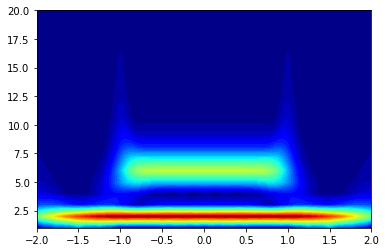

In [8]:
# plot
freqs = np.arange(1,21)
conv_res = [compute_mwt(signal, 1000,peak_freq=f, n=6) for f in freqs]
pwr = [abs(np.array(c)) for c in conv_res]

f, ax = plt.subplots(1,1)
cs = ax.contourf(time, freqs, pwr,50, cmap='jet')
print(np.max(pwr))

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


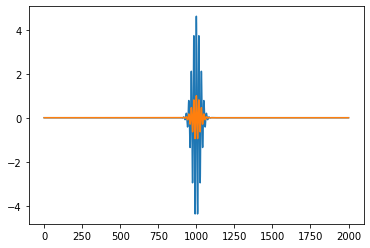

In [9]:
# generating our wavelet
peak_freq = 60
fs = 1000
n=10

f = peak_freq
t = np.arange(-1, 1 + 1/fs, 1/fs)
s = n/(2*np.pi*f)

wavelet = np.sqrt(1/(s*np.sqrt(np.pi)))*np.exp(2*np.pi*1j*f*t) * np.exp(-t**2/(2*s**2))
wavelet1 = np.exp(2*np.pi*1j*f*t) * np.exp(-t**2/(2*s**2))

plt.plot(wavelet)
plt.plot(wavelet1)

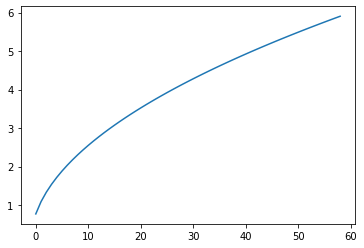

In [10]:
scaling = []
for f in range(1,60):
    s = 6/(2*np.pi*f)
    x = np.sqrt(1/(s*np.sqrt(np.pi)))
    scaling.append(x)

plt.plot(scaling)